In [1]:
#| default_exp diffusion

TODO:

SimpleDiffusion

# [50% Failed] Diffusion unet

In [2]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
#| export
from miniai.imports import *

from einops import rearrange
from fastprogress import progress_bar

In [4]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [5]:
class GPUCUDAMissing(BaseException):
    pass
    
try:
    if torch.cuda.is_available():
        print('# of GPUs available = ', torch.cuda.device_count())
    else:
        raise GPUCUDAMissing
except:
    print("ERROR: GPU is missing")

# of GPUs available =  1


In [6]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
bs = 512
dsd = load_dataset(name)

In [7]:
dsd['train'] = dsd['train'].select(range(7500))

In [8]:
dsd['valid'] = dsd['valid'].select(range(750))

In [9]:
class TinyHFDS:
    # this is specific for Hugging Face's dsd which can be very slow to index
    def __init__(self, hg_ds):
        self.ds = hg_ds
        # the 2 lines below must be done here because the execution of "ds['train']['image']" takes 18seconds
        # once it has executed, indexing it is very fast (5 milliseconds)
        self.image = hg_ds[xl]
        self.label = hg_ds[yl]
    def __len__(self): return self.ds.num_rows
    def __getitem__(self, i): return TF.to_tensor(self.image[i]), self.label[i]

In [10]:
tds = TinyHFDS(dsd['train'])

In [11]:
vds = TinyHFDS(dsd['valid'])

In [12]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

### img is downscaled to 32x32

In [13]:
def tfmx(x):
    try:
        if len(x.shape) == 3 and x.shape[0] == 3:
            pass
        else:
            x = torch.ones([3,1,1]) * x
        x = F.interpolate(x.unsqueeze(0), scale_factor=0.5, mode='bilinear', align_corners=True)
        x = x.squeeze()-0.5
    except SomeException:
        print("ERROR: x doesn't have 3 channels")
    return x

In [14]:
def tfmy(y): 
    return y

In [15]:
tfm_tds = TfmDS(tds, tfmx, tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [16]:
def collate_fn(b):
    b = default_collate(b)
    return b

In [17]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=0, collate_fn=collate_fn))

In [18]:
dt = dls.train

In [19]:
xb, yb = next(iter(dt))

In [20]:
xb.shape, yb.shape, xb.min(), xb.max()

(torch.Size([512, 3, 32, 32]),
 torch.Size([512]),
 tensor(-0.5000),
 tensor(0.5000))

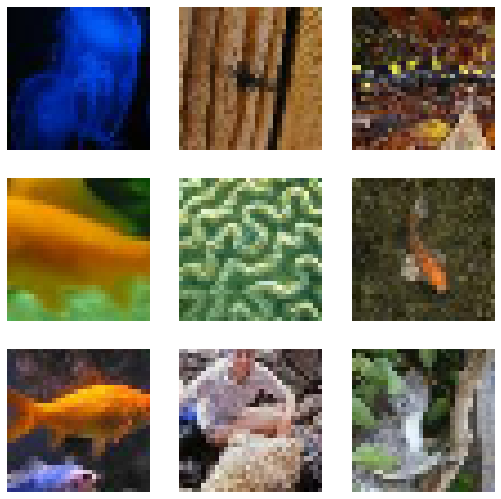

In [21]:
show_images(xb[:9]+0.5)

### DDIM

In [22]:
#| export
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0,0.999)
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): 
    b = default_collate(b)
    return noisify(b[0])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [23]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8, collate_fn=collate_ddpm))

/home/fastai_pyenv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 7, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
dt = dls.train

In [25]:
xb, yb = next(iter(dt))

In [26]:
xb[0].shape, xb[1].shape, yb.shape

(torch.Size([512, 3, 32, 32]), torch.Size([512]), torch.Size([512, 3, 32, 32]))

In [27]:
xb[0].min(), xb[0].max()

(tensor(-4.4715), tensor(4.6712))

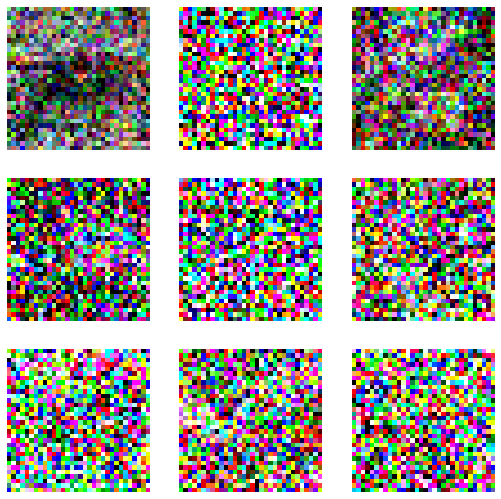

In [28]:
show_images((xb[0][:9,:,:]+0.5).clamp(0,1))

## Train

Based on Diffusers

In [29]:
#| export
def timestep_embedding(tsteps, emb_dim, max_period= 10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:,None].float() * exponent.exp()[None,:]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb

In [30]:
#| export
def pre_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return layers

In [31]:
#| export
def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))

In [32]:
#| export
def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    layers = nn.Sequential()
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Linear(ni, nf, bias=bias))
    return layers

In [33]:
# This version is giving poor results - use the cell below instead
class SelfAttention(nn.Module):
    def __init__(self, ni, attn_chans):
        super().__init__()
        self.attn = nn.MultiheadAttention(ni, ni//attn_chans, batch_first=True)
        self.norm = nn.BatchNorm2d(ni)

    def forward(self, x):
        n,c,h,w = x.shape
        x = self.norm(x).view(n, c, -1).transpose(1, 2)
        x = self.attn(x, x, x, need_weights=False)[0]
        return x.transpose(1,2).reshape(n,c,h,w)

In [34]:
#| export
class SelfAttention(nn.Module):
    def __init__(self, ni, attn_chans, transpose=True):
        super().__init__()
        self.nheads = ni//attn_chans
        self.scale = math.sqrt(ni/self.nheads)
        self.norm = nn.LayerNorm(ni)
        self.qkv = nn.Linear(ni, ni*3)
        self.proj = nn.Linear(ni, ni)
        self.t = transpose
    
    def forward(self, x):
        n,c,s = x.shape
        if self.t: x = x.transpose(1, 2)
        x = self.norm(x)
        x = self.qkv(x)
        x = rearrange(x, 'n s (h d) -> (n h) s d', h=self.nheads)
        q,k,v = torch.chunk(x, 3, dim=-1)
        s = (q@k.transpose(1,2))/self.scale
        x = s.softmax(dim=-1)@v
        x = rearrange(x, '(n h) s d -> n s (h d)', h=self.nheads)
        x = self.proj(x)
        if self.t: x = x.transpose(1, 2)
        return x

In [35]:
#| export
class SelfAttention2D(SelfAttention):
    def forward(self, x):
        n,c,h,w = x.shape
        return super().forward(x.view(n, c, -1)).reshape(n,c,h,w)

In [36]:
#| export
class EmbResBlock(nn.Module):
    def __init__(self, n_emb, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d, attn_chans=0):
        super().__init__()
        if nf is None: nf = ni
        self.emb_proj = nn.Linear(n_emb, nf*2)
        self.conv1 = pre_conv(ni, nf, ks, act=act, norm=norm)
        self.conv2 = pre_conv(nf, nf, ks, act=act, norm=norm)
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)
        self.attn = False
        if attn_chans: self.attn = SelfAttention2D(nf, attn_chans)

    def forward(self, x, t):
        inp = x
        x = self.conv1(x)
        emb = self.emb_proj(F.silu(t))[:, :, None, None]
        scale,shift = torch.chunk(emb, 2, dim=1)
        x = x*(1+scale) + shift
        x = self.conv2(x)
        x = x + self.idconv(inp)
        if self.attn: x = x + self.attn(x)
        return x

In [37]:
#| export
def saved(m, blk):
    m_ = m.forward

    @wraps(m.forward)
    def _f(*args, **kwargs):
        res = m_(*args, **kwargs)
        blk.saved.append(res)
        return res

    m.forward = _f
    return m

In [38]:
#| export
class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList([saved(EmbResBlock(n_emb, ni if i==0 else nf, nf, attn_chans=attn_chans), self)
                                      for i in range(num_layers)])
        self.down = saved(nn.Conv2d(nf, nf, 3, stride=2, padding=1), self) if add_down else nn.Identity()

    def forward(self, x, t):
        self.saved = []
        for resnet in self.resnets: x = resnet(x, t)
        x = self.down(x)
        return x

In [39]:
#| export
class UpBlock(nn.Module):
    def __init__(self, n_emb, ni, prev_nf, nf, add_up=True, num_layers=2, attn_chans=0):
        super().__init__()
        self.resnets = nn.ModuleList(
            [EmbResBlock(n_emb, (prev_nf if i==0 else nf)+(ni if (i==num_layers-1) else nf), nf, attn_chans=attn_chans)
            for i in range(num_layers)])
        self.up = upsample(nf) if add_up else nn.Identity()

    def forward(self, x, t, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1), t)
        return self.up(x)

In [40]:
#| export
class EmbUNetModel(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1, attn_chans=8, attn_start=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        n = len(nfs)
        for i in range(n):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=n-1, num_layers=num_layers,
                                        attn_chans=0 if i<attn_start else attn_chans))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(n):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=n-1, num_layers=num_layers+1,
                                    attn_chans=0 if i>=n-attn_start else attn_chans))
        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x,t = inp
        temb = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(temb)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

In [41]:
#| export
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig, clamp=True):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt())
    if clamp: x_0_hat = x_0_hat.clamp(-1,1)
    if bbar_t1<=sig**2+0.01: sig=0.  # set to zero if very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat,x_t

In [42]:
#| export
@torch.no_grad()
def sample(f, model, sz, steps, eta=1., clamp=True, progress=False):
    model.eval()
    ts = torch.linspace(1-1/steps,0,steps)
    x_t = torch.randn(sz).cuda()
    preds = []
    tbe = progress_bar(ts) if progress else ts 
    for i,t in enumerate(tbe):
        t = t[None].cuda()
        abar_t = abar(t)
        noise = model((x_t, t))
        abar_t1 = abar(t-1/steps) if t>=1/steps else torch.tensor(1)
        x_0_hat,x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100), clamp=clamp)
        preds.append(x_0_hat.float().cpu())
    return preds

In [43]:
import wandb

class WandBCB(MetricsCB):
    order=100
    def __init__(self, config, *ms, project='ddpm_tinyimgnet', **metrics):
        fc.store_attr()
        super().__init__(*ms, **metrics)
        
    def before_fit(self, learn): wandb.init(project=self.project, config=self.config)
    def after_fit(self, learn): wandb.finish()

    def _log(self, d):
        #import pdb; pdb.set_trace()
        if learn.model.training: 
            wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
        else: 
            wandb.log({'val_'+m:float(d[m]) for m in self.all_metrics})
            wandb.log({'samples':self.sample_figure(learn)})
        print(d)

        
    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(ddim_step, model, (16, 3, 32, 32), steps=100, eta=1.)
        s = (samples[-1]+0.5).clamp(0,1)
        plt.clf()
        fig, axs = get_grid(16, imsize=3)
        for im,ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig

    def after_batch(self, learn):
        super().after_batch(learn) 
        wandb.log({'loss':learn.loss})

In [44]:
def init_ddpm(model):
    for o in model.downs:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
        for p in o.resnets: p.conv2[-1].weight.data.zero_()

In [45]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = '07_diffusion-attn-cond_tin.ipynb'
lr = 5e-3
epochs = 100
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'comments':'default unet logging test'})
cbs = [DeviceCB(), ProgressCB(plot=True), wandbcb, BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=3, out_channels=3, nfs=(32,64,128,256,512), num_layers=2)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

wandb: Currently logged in as: dumbdude (dumbdude-none). Use `wandb login --relogin` to force relogin


/home/fastai_pyenv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 7, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 2.3 seconds.), retrying request
wandb: 429 encountered (Filestream rate limit exceeded, retrying in 4.5 seconds.), retrying request


{'loss': '0.809', 'epoch': 0, 'train': 'train'}


wandb: 429 encountered (Filestream rate limit exceeded, retrying in 8.5 seconds.), retrying request


{'loss': '0.864', 'epoch': 0, 'train': 'eval'}


wandb: 429 encountered (Filestream rate limit exceeded, retrying in 16.6 seconds.), retrying request


{'loss': '0.388', 'epoch': 1, 'train': 'train'}
{'loss': '0.428', 'epoch': 1, 'train': 'eval'}
{'loss': '0.237', 'epoch': 2, 'train': 'train'}
{'loss': '0.224', 'epoch': 2, 'train': 'eval'}


wandb: 429 encountered (Filestream rate limit exceeded, retrying in 38.0 seconds.), retrying request


{'loss': '0.172', 'epoch': 3, 'train': 'train'}
{'loss': '0.181', 'epoch': 3, 'train': 'eval'}
{'loss': '0.140', 'epoch': 4, 'train': 'train'}
{'loss': '0.141', 'epoch': 4, 'train': 'eval'}
{'loss': '0.126', 'epoch': 5, 'train': 'train'}
{'loss': '0.122', 'epoch': 5, 'train': 'eval'}
{'loss': '0.112', 'epoch': 6, 'train': 'train'}
{'loss': '0.116', 'epoch': 6, 'train': 'eval'}


wandb: 429 encountered (Filestream rate limit exceeded, retrying in 78.9 seconds.), retrying request


{'loss': '0.096', 'epoch': 7, 'train': 'train'}
{'loss': '0.106', 'epoch': 7, 'train': 'eval'}
{'loss': '0.095', 'epoch': 8, 'train': 'train'}
{'loss': '0.105', 'epoch': 8, 'train': 'eval'}
{'loss': '0.089', 'epoch': 9, 'train': 'train'}
{'loss': '0.087', 'epoch': 9, 'train': 'eval'}
{'loss': '0.087', 'epoch': 10, 'train': 'train'}
{'loss': '0.089', 'epoch': 10, 'train': 'eval'}
{'loss': '0.086', 'epoch': 11, 'train': 'train'}
{'loss': '0.082', 'epoch': 11, 'train': 'eval'}
{'loss': '0.083', 'epoch': 12, 'train': 'train'}
{'loss': '0.088', 'epoch': 12, 'train': 'eval'}
{'loss': '0.079', 'epoch': 13, 'train': 'train'}
{'loss': '0.080', 'epoch': 13, 'train': 'eval'}
{'loss': '0.077', 'epoch': 14, 'train': 'train'}
{'loss': '0.085', 'epoch': 14, 'train': 'eval'}
{'loss': '0.081', 'epoch': 15, 'train': 'train'}


wandb: 429 encountered (Filestream rate limit exceeded, retrying in 155.1 seconds.), retrying request


{'loss': '0.090', 'epoch': 15, 'train': 'eval'}
{'loss': '0.077', 'epoch': 16, 'train': 'train'}
{'loss': '0.080', 'epoch': 16, 'train': 'eval'}
{'loss': '0.072', 'epoch': 17, 'train': 'train'}
{'loss': '0.073', 'epoch': 17, 'train': 'eval'}
{'loss': '0.070', 'epoch': 18, 'train': 'train'}
{'loss': '0.077', 'epoch': 18, 'train': 'eval'}
{'loss': '0.075', 'epoch': 19, 'train': 'train'}


/home/course22p2/miniai/datasets.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)


{'loss': '0.080', 'epoch': 19, 'train': 'eval'}
{'loss': '0.071', 'epoch': 20, 'train': 'train'}
{'loss': '0.067', 'epoch': 20, 'train': 'eval'}
{'loss': '0.070', 'epoch': 21, 'train': 'train'}
{'loss': '0.084', 'epoch': 21, 'train': 'eval'}
{'loss': '0.069', 'epoch': 22, 'train': 'train'}
{'loss': '0.087', 'epoch': 22, 'train': 'eval'}
{'loss': '0.072', 'epoch': 23, 'train': 'train'}
{'loss': '0.073', 'epoch': 23, 'train': 'eval'}
{'loss': '0.068', 'epoch': 24, 'train': 'train'}
{'loss': '0.072', 'epoch': 24, 'train': 'eval'}
{'loss': '0.072', 'epoch': 25, 'train': 'train'}
{'loss': '0.070', 'epoch': 25, 'train': 'eval'}
{'loss': '0.066', 'epoch': 26, 'train': 'train'}
{'loss': '0.070', 'epoch': 26, 'train': 'eval'}
{'loss': '0.068', 'epoch': 27, 'train': 'train'}
{'loss': '0.075', 'epoch': 27, 'train': 'eval'}
{'loss': '0.066', 'epoch': 28, 'train': 'train'}
{'loss': '0.075', 'epoch': 28, 'train': 'eval'}
{'loss': '0.066', 'epoch': 29, 'train': 'train'}
{'loss': '0.063', 'epoch': 29,

loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.05484
train_loss,0.054
val_loss,0.055


<Figure size 448x336 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

<Figure size 840x840 with 0 Axes>

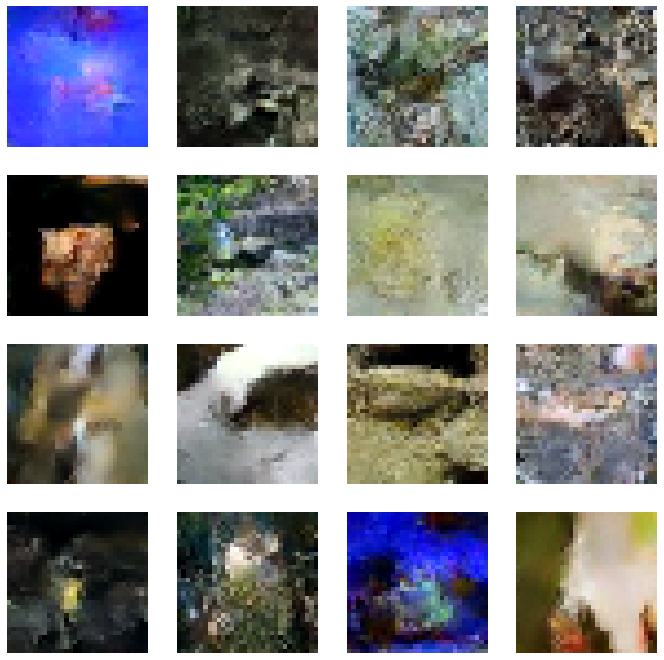

In [46]:
learn.fit(epochs)

## Sampling

In [47]:
from miniai.fid import ImageEval

cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [48]:
sz = (64,3,32,32)

In [49]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]+0.5)
s.min(),s.max(),s.shape

(tensor(-0.1196), tensor(1.2355), torch.Size([64, 3, 32, 32]))

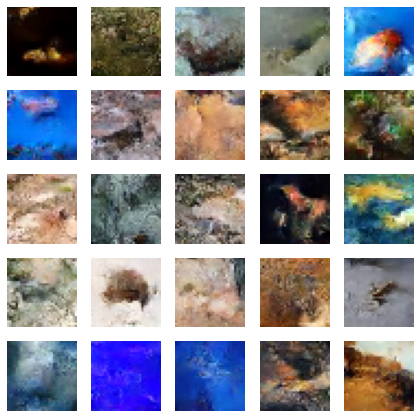

In [50]:
show_images(s[:25].clamp(0,1), imsize=1.5)